<a href="https://colab.research.google.com/github/serg-kas/NN-archive/blob/main/%D0%90%D0%BF%D1%80%D0%B5%D0%BB%D1%8C%D1%81%D0%BA%D0%B8%D0%B9_%D0%BA%D1%83%D1%80%D1%81_2020_Light_%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_19_%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8_%D0%B4%D0%BB%D1%8F_%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D1%8F_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B8_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Light задание##
Используя шаблон ноутбука (для базы квартир), требуется:

1. Загрузить xTrain на числовых данных
2. Загрузить xTrainС из "Примечаний" (тексты)
3. Создать словарь
4. Превратить xTrainC в формат bag of words (2000 самых популярных слов)
5. Сделать нормирование данных
6. Написать нейронную сеть

##Импорт библиотек##

In [ ]:
import numpy as np
import pandas as pd

from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler

from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D
from tensorflow.keras.callbacks import LambdaCallback # подключаем колбэки
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import LearningRateScheduler

from google.colab import files

import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import time

from IPython.display import clear_output




In [ ]:
# Подключаем google drive
from google.colab import drive # Подключаем диск
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# и загружаем данные в data frame
df = pd.read_csv('/content/drive/My Drive/my_sample_data/Д.З.19/moscow.csv', sep=";") 

df = df.iloc[::2,:] #Выбираем нечётные строки, в чётных строках в исходном фрейме пустые строки для комментариев
data = df.values #Вытаскиваем данные в numpy array

print(df.iloc[:,:6].head(20)) #Показываем пример данных (первые 6 колонок)

   Комнат        Метро / ЖД станции От станции        Дом Балкон Санузел
0       1               Шелепиха м.        12п    35/37 М    NaN       2
2       1        Пятницкое шоссе м.        30т    11/14 П      Л       Р
4       1              Планерная м.         5т    11/22 П      Б       С
6       1            Шаболовская м.        12п     8/12 ?      Б       Р
8       1           Бабушкинская м.        15п     4/14 П    NaN       С
10      1               Шелепиха м.        15п     9/36 К    NaN     NaN
12      1    Улица Дмитриевского м.         2п     7/16 П      Л       Р
14      1  Бульвар Рокоссовского м.         2п      2/5 К      Б       С
16      1           Марьина Роща м.        10п     7/14 П     2Б     NaN
18      1                Марьино м.        20п  10/24 М-К    NaN       -
20      1                Марьино м.         5т      5/5 П      Б       С
22      1              Печатники м.         5т     2/12 П      -       С
24      1      Красногвардейская м.         3п    2

In [ ]:
print(df.columns) #Показываем имена колонок данных

#В xTrain - база числовых значени
#Комнат
#Метро / ЖД станции
#От станции
#Дом
#Балкон
#Санузел
#Площадь

#В xTrainC - база текстов о квартирах
#Примечание

#В yTrain
#Цена, руб.

#Остальные колонки игнорируем

Index(['Комнат', 'Метро / ЖД станции', 'От станции', 'Дом', 'Балкон',
       'Санузел', 'Площадь', 'Цена, руб.', 'ГРМ', 'Бонус агенту', 'Дата',
       'Кол-во дней в экспозиции', 'Источник', 'Примечание'],
      dtype='object')


#Функции парсинга

In [ ]:
#Во всех функциях дальше
#d - описание квартиры, одна строка из data1


#Вычисляем количество комнат
#maxRoomCount - максимальное число комнат в квартире
def getRoomsCount(d, maxRoomCount):
  roomsCountStr = d[0] #Получаем строку с числом комнат

  roomsCount = 0
  try:
    roomsCount = int(roomsCountStr) #Пробуем превратить строку в число
    if (roomsCount > maxRoomCount): 
      roomsCount = maxRoomCount #Если число комнат больше максимального, то присваиваем максимальное
  except: #Если не получается превратить строку в число
    if (roomsCountStr == roomsCountStr): #Проверяем строку на nan (сравнение с самим собой)
      if ("Ст" in roomsCountStr): #ЕСть строка = "Ст", значит это Студия
        roomsCount = maxRoomCount + 1

  return roomsCount

#Превращаем число комнат в категорию
def getRoomsCountCategory(d, maxRoomCount):
  roomsCount = getRoomsCount(d, maxRoomCount) #Получаем число комнат
  roomsCount = utils.to_categorical(roomsCount, maxRoomCount+2) #Превращаем в категорию
  #maxRoomCount+2 потому что 0 зарезервирован на неопознаное число комнат, а maxRoomCount+1 на "Студию"
  return roomsCount

#Получаем индекс станции метро
#allMetroNames - все уникальные названия метро в базе
def getMetro(d, allMetroNames):
  metroStr = d[1] #Получаем строку метро
  metro = 0
  
  if (metroStr in allMetroNames): #Если находим метро во всех названиях
    metro = allMetroNames.index(metroStr)+1 #Присваиваем индекс
    #+1 так как 0 зарезервирован на неопознанное метро
    
  return metro

#Получаем тип метро
#0 - внутри кольца
#1 - кольцо
#2 - 1-3 станции от конца
#3 - 4-8 станций от кольца
#4 - больше 8 станций от кольца
def getMetroType(d):
  metroTypeStr = d[1] #Получаем строку метро
  metroTypeClasses = 5 #Число классов метро
  metroType = metroTypeClasses - 1 #Изначально считаем последний класс
  
  #Метро внутри кольца
  metroNamesInsideCircle = ["Площадь Революции", "Арбатская", "Смоленская", "Красные Ворота", "Чистые пруды", "Лубянка", "Охотный Ряд", "Библиотека имени Ленина", "Кропоткинская", "Сухаревская", "Тургеневская", "Китай-город", "Третьяковская", "Трубная", "Сретенский бульвар", "Цветной бульвар", "Чеховская", "Боровицкая", "Полянка", "Маяковская", "Тверская", "Театральная", "Новокузнецкая", "Пушкинская", "Кузнецкий Мост", "Китай-город", "Александровский сад"]
  #Метро на кольце
  metroNamesCircle = ["Киевская", "Парк Культуры", "Октябрьская", "Добрынинская", "Павелецкая", "Таганская", "Курская", "Комсомольская", "Проспект Мира", "Новослободская", "Белорусская", "Краснопресненская"]
  #Метро 1-3 станции от кольца
  metroNames13FromCircle = ["Бауманская", "Электрозаводская", "Семёновская", "Площадь Ильича", "Авиамоторная", "Шоссе Энтузиастов", "Римская", "Крестьянская Застава", "Дубровка", "Пролетарская", "Волгоградский проспект", "Текстильщики", "Автозаводская", "Технопарк", "Коломенская", "Тульская", "Нагатинская", "Нагорная", "Шаболовская", "Ленинский проспект", "Академическая", "Фрунзенская", "Спортивная", "Воробьёвы горы", "Студенческая", "Кутузовская", "Фили", "Парк Победы", "Выставочная", "Международная", "Улица 1905 года", "Беговая", "Полежаевская", "Динамо", "Аэропорт", "Сокол", "Деловой центр", "Шелепиха", "Хорошёвская", "ЦСКА", "Петровский парк", "Савёловская", "Дмитровская", "Тимирязевская", "Достоевская", "Марьина Роща", "Бутырская", "Фонвизинская", "Рижская", "Алексеевская", "ВДНХ", "Красносельская", "Сокольники", "Преображенская площадь"]
  #Метро 4-8 станций от кольа
  metroNames48FromCircle = ["Партизанская", "Измайловская", "Первомайская", "Щёлковская", "Новокосино", "Новогиреево", "Перово", "Кузьминки", "Рязанский проспект", "Выхино", "Лермонтовский проспект", "Жулебино", "Партизанская", "Измайловская", "Первомайская", "Щёлковская", "Новокосино", "Новогиреево", "Перово", "Кузьминки", "Рязанский проспект", "Выхино", "Лермонтовский проспект", "Жулебино", "Улица Дмитриевского", "Кожуховская", "Печатники", "Волжская", "Люблино", "Братиславская", "Коломенская", "Каширская", "Кантемировская", "Царицыно", "Орехово", "Севастопольская", "Чертановская", "Южная", "Пражская", "Варшавская", "Профсоюзная", "Новые Черёмушки", "Калужская", "Беляево", "Коньково", "Университет", "Багратионовская", "Филёвский парк", "Пионерская", "Кунцевская", "Молодёжная", "Октябрьское Поле", "Щукинская", "Спартак", "Тушинская", "Сходненская", "Войковская", "Водный стадион", "Речной вокзал", "Беломорская", "Ховрино", "Петровско-Разумовская", "Владыкино", "Отрадное", "Бибирево", "Алтуфьево", "Фонвизинская", "Окружная", "Верхние Лихоборы", "Селигерская", "ВДНХ", "Ботанический сад", "Свиблово", "Бабушкинская", "Медведково", "Преображенская площадь", "Черкизовская", "Бульвар Рокоссовского"]
  
  #Проверяем, в какую категорию попадает наша станция
  if (metroTypeStr in metroNamesInsideCircle):
    metroType = 0
  if (metroTypeStr in metroNamesCircle):
    metroType = 1
  if (metroTypeStr in metroNames13FromCircle):
    metroType = 2
  if (metroTypeStr in metroNames48FromCircle):
    metroType = 3
  
  #Превращаем результат в категорию
  metroType = utils.to_categorical(metroType, metroTypeClasses)
  return metroType


#Вычисляем растояние до метро
def getMetroDistance(d):
  metroDistanceStr = d[2] #Получаем строку
  
  metroDistance = 0 #Расстояние до метро
  metroDistanceType = 0 #Тип расстояния - пешком или на транспорте
  
  #ЕСли строка не равна nan  
  if (metroDistanceStr == metroDistanceStr):
    if (len(metroDistanceStr) > 0):
      #Определяем тип расстояния
      if (metroDistanceStr[-1] == "п"):
        metroDistanceType = 1 #Пешком
      elif (metroDistanceStr[-1] == "т"):
        metroDistanceType = 2 #На транспорте

      #Выбрасываем последний символ, чтобы осталось только число
      metroDistanceStr = metroDistanceStr[:-1]
      try:
        #Разделяем дистанции на категории
        metroDistance = int(metroDistanceStr)
        if (metroDistance < 3):
          metroDistance = 1
        elif (metroDistance < 6):
          metroDistance = 2
        elif (metroDistance < 10):
          metroDistance = 3
        elif (metroDistance < 15):
          metroDistance = 4
        elif (metroDistance < 20):
          metroDistance = 5
        else:
          metroDistance = 6
      except: #Если в строке не число, то категория 0
        metroDistance = 0
  
  #Число классов дистанции
  metroDistanceClasses = 7
  
  #У нас 7 категорий дистанции по расстоянию
  #И 3 типа дистанции - неопознанный, пешком и транспортом
  #Мы создадим вектор длины 3*7 = 21
  #Будем преобразовывать индекс расстояния 0-6 в 0-20
  #Для типа "Пешком" - ничего не меняем
  if (metroDistanceType == 2):
    metroDistance += metroDistanceClasses #Для типа "Транспортом" добавляем 7
  if (metroDistanceType == 0):
    metroDistance += 2*metroDistanceClasses #Для неопознанного типа добавляем 14
    
  #Превращаем в категории
  metroDistance = utils.to_categorical(metroDistance, 3*metroDistanceClasses)
  return metroDistance

#Получаем 4 данных
#- этаж квартиры
#- этажность дома
#- индикатор, что последний этаж
#- тип дома
def getHouseTypeAndFloor(d):
  try:
    houseStr = d[3] #Получаем строку типа дома и этажей
  except:
    houseStr = ""
  
  houseType = 0 #Тип дома
  floor = 0 #Этаж квартиры
  floors = 0 #Этажность дома
  isLastFloor = 0 #Индикатор последнего этажа
  
  #Проверяем строку на nan
  if (houseStr == houseStr):
    if (len(houseStr) > 1):
    
      try:
        slashIndex = houseStr.index("/") #Ищем разделитель /
      except:
        print(houseStr)

      try:
        spaceIndex = houseStr.index(" ") #Ищем разделитель " "
      except:
        print(houseStr)

      #Вытаскиваем строки
      floorStr = houseStr[:slashIndex] #Строка этажа
      floorsStr = houseStr[slashIndex+1:spaceIndex] #Строка этажности дома
      houseTypeStr = houseStr[spaceIndex+1:] #Строка типа дома

      #Выбираем категорию этажа
      try:
        floor = int(floorStr) #Превращаем строку в число
        floorSave = floor
        if (floorSave < 5):
          floor = 2
        if (floorSave < 10):
          floor = 3
        if (floorSave < 20):
          floor = 4
        if (floorSave >= 20):
          floor = 5
        if (floorSave == 1): #Первый этаж выделяем в отдельную категорию
          floor = 1 

        if (floor == floors): #Если этаж последний, включаем индикатор последнего этажа
          isLastFloor = 1 
      except:
        floor = 0 #Если строка не парсится в число, то категория этажа = 0 (отдельная)

      #Выбираем категорию этажности дома
      try:
        floors = int(floorsStr) #Превращаем строку в число
        floorsSave = floors
        if (floorsSave < 5):
          floors = 1
        if (floorsSave < 10):
          floors = 2
        if (floorsSave < 20):
          floors = 3
        if (floorsSave >= 20):
          floors = 4
      except:
        floors = 0 #Если строка не парсится в число, то категория этажности = 0 (отдельная)

      #Определяем категорию типа дома
      if (len(houseTypeStr) > 0):
        if ("М" in houseTypeStr): 
          houseType = 1
        if ("К" in houseTypeStr): 
          houseType = 2
        if ("П" in houseTypeStr): 
          houseType = 3
        if ("Б" in houseTypeStr): 
          houseType = 4
        if ("?" in houseTypeStr): 
          houseType = 5
        if ("-" in houseTypeStr): 
          houseType = 6
    
    #Превращаем все категории в one hot encoding
    floor = utils.to_categorical(floor, 6)
    floors = utils.to_categorical(floors, 5)
    houseType = utils.to_categorical(houseType, 7)
    
    
  return floor, floors, isLastFloor, houseType


#Вычисляем тип балкона
def getBalcony(d):
  balconyStr = d[4] #Полуаем строку
  #Выписываем все варианты балконов в базе
  balconyVariants = ['Л', 'Б', '2Б', '-', '2Б2Л', 'БЛ', '3Б', '2Л', 'Эрк', 'Б2Л', 'ЭркЛ', '3Л', '4Л', '*Л', '*Б']
  #Проверяем на nan
  if (balconyStr == balconyStr):
    balcony = balconyVariants.index(balconyStr)+1 #Находим индекс строки балкона во всех строках
  else:
    balcony = 0 #Индекс 0 выделяем на строку nan
  
  #Превращаем в one hot encoding
  balcony = utils.to_categorical(balcony, 16)
  
  return balcony

#Определяем тип санузла
def getWC(d):
  wcStr = d[5] #Получаем строку
  #Выписываем все варианты санузлов в базе
  wcVariants = ['2', 'Р', 'С', '-', '2С', '+', '4Р', '2Р', '3С', '4С', '4', '3', '3Р']
  #Проверяем на nan
  if (wcStr == wcStr):
    wc = wcVariants.index(wcStr)+1 #Находим индекс строки санузла во всех строках
  else:
    wc = 0 #Индекс 0 выделяем на строку nan
  
  #Превращаем в one hot encoding
  wc = utils.to_categorical(wc, 14)
  
  return wc

#Определяем площадь
def getArea(d):
  areaStr = d[6] #Полулачем строку площади
  
  if ("/" in areaStr):
    slashIndex = areaStr.index("/") #Находим разделитель /
    try:
      area = float(areaStr[:slashIndex]) #Берём число до разделителя и превращаем в число
    except:
      area = 0 #Если не получается, возвращаем 0
  else:
    area = 0 #Или если нет разделителя, возвращаем 0
    
  return area

#Полуаем цену
def getCost(d):
  costStr = d[7] #Загружаем строку
  
  try:
    cost = float(costStr) #Пробуем превратить в число
  except:
    cost = 0 #Если не получается, возвращаем 0
  
  return cost

#Получаем комментарий
def getComment(d):
  commentStr = d[-1] #Возвращаем данные из последней колонки
  
  return commentStr

#Объединяем все числовые параметры вместе
def getAllParameters(d, allMetroNames):
  #Загружаем все данные по отдельности
  roomsCountType = getRoomsCountCategory(d, 30)
  metro = getMetro(d, allMetroNames)
  metroType = getMetroType(d)
  metroDistance = getMetroDistance(d)
  floor, floors, isLastFloor, houseType = getHouseTypeAndFloor(d)
  balcony = getBalcony(d)
  wc = getWC(d)
  area = getArea(d)

  #Объединяем в один лист
  out = list(roomsCountType)
  out.append(metro)
  out.extend(metroType)
  out.extend(metroDistance)
  out.extend(floor)
  out.extend(floors)
  out.append(isLastFloor)
  out.extend(houseType)
  out.extend(balcony)
  out.extend(wc)
  out.append(area)
  
  return out

#Генерируем обучающаюу выборку - xTrain
def getXTrain(data):
  
  #Получаем строку во всеми вариантами метро
  allMertroNames = list(df["Метро / ЖД станции"].unique())
  
  #Превращаем все строки в data1 в векторы параметров и записываем в xTrain
  xTrain = [getAllParameters(d, allMertroNames) for d in data]
  xTrain = np.array(xTrain)
  
  return xTrain

#Генерируем обучающую выборку - yTrain
def getYTrain(data):
  
  #Загружаем лист всех цен квартир по всем строкам data1
  costList = [getCost(d) for d in data] 
  yTrain = np.array(costList)
  
  return yTrain

##Формируем обучающую выборку

In [ ]:
# Начинаем предобработку (чистку)

oneRoomMask = [getRoomsCount(d, 30) == 1 for d in data] #Делаем маску однокомнатных квартир, принцип (getRoomsCount(d, 30) == 1)
data1 = data[oneRoomMask] #В data1 оставляем только однокомнатные квартиры

#НЕ ХВАТАЕТ ОЗУ
#data1 = data


print(data.shape)
print(data1.shape)

(126268, 14)
(62504, 14)


In [ ]:
xTrain = getXTrain(data1)
yTrain = getYTrain(data1)

print(xTrain.shape)
print(yTrain.shape)

(62504, 109)
(62504,)


##Парсинг текста

In [ ]:
###########################
# Очистка текста и превращение в набор слов
##########################
def text2Words(text):

  #Удаляем лишние символы
  text = text.replace(".", "")
  text = text.replace("—", "")
  text = text.replace(",", "")
  text = text.replace("!", "")
  text = text.replace("?", "")
  text = text.replace("…", "")
  text = text.lower() #Переводим в нижний регистр
  
  
  words = [] #Тут будут все слов
  currWord = "" #Тут будет накапливаться текущее слово, между двумя пробелами
  
  #идём по всем символам
  for symbol in text:
    
    if (symbol != "\ufeff"): #Игнорируем системынй символ в начале строки
      if (symbol != " "): #Если символ не пробел
        currWord += symbol #То добавляем вимвол в текущее слово
      else: #Если символ пробел
        if (currWord != ""): 
          words.append(currWord) #Добавляем тккущее слово в список слов
          currWord = "" #И обнуляем текущее слово

  #Добавляем финальное слово, если оно не пустое
  #Если не сделать, то потеряем финальное слово, потому что текст чаще всего заканчивается на не пробел
  if (currWord != ""):
        words.append(currWord)
  
  return words


###########################
# Создание словаря - все слова, упорядоченные по частоте появления
##########################
def createVocabulary(allWords):
  
  #Создаём словарь, в котором будут слова и количество их поялвений во всём текста
  #Ключи - все наши слова
  #Количество появлений пока везде 0
  wCount = dict.fromkeys(allWords, 0)

  #Проходим по всем словам
  for word in allWords:
    wCount[word] += 1 #И увеличиаем количество появлений текущего слова на 1

  #Выцепляем лист из словаря
  wordsList = list(wCount.items())
  #И сортируем по частоте появления
  wordsList.sort(key = lambda i:i[1], reverse=1)
  #key = lambda i:i[1] - говорит, что сортировать надо по частоте появления
  #В i[0] у нас слово, в i[1] - частота появления
  #reverse=1 говорить сортироваться по убыванию

  sortedWords = [] #Тут будет лист всех отсортированных слов

  #Проходим по всем словам в отсортированном списке
  for word in wordsList:
    sortedWords.append(word[0]) #Докидываем слово в лист отсортированных слов

  #Это словарь слово - индекс
  #Изначально заполнен всеми словами
  #У всех индекс 0
  wordIndexes = dict.fromkeys(allWords, 0)
  #Проходим по всем словам
  for word in wordIndexes.keys():
    wordIndexes[word] = sortedWords.index(word)+1 #Ставим индекс = индекс слова в отсортированном листе слов + 1
    #+1 потому, что индекс 0 резервируем под неопознанные слова

  return wordIndexes


###########################
# Преобразования листа слов в лист индексов
##########################
def words2Indexes(words, vocabulary, maxWordsCount):
  wordsIndexes = []
  
  #Идём по всем словая
  for word in words:
    
    wordIndex = 0 #Тут будет индекс слова, изначально 0 - слово неопознано
    wordInVocabulary = word in vocabulary #Проверяем, есть ли слово в словаре
    
    #Если слово есть в словаре
    if (wordInVocabulary):
      index = vocabulary[word] #Индекс = индексу слова в словаре
      if (index < maxWordsCount): #Если индекс ниже maxWordsCount - черты отсечения слов
        wordIndex = index #То записываем индекс
      #Иначе останется значение 0
        
    wordsIndexes.append(wordIndex)
    
  return wordsIndexes


###########################
# Преобразование одного короткого вектора в вектор из 0 и 1
# По принципу words bag
##########################
def changeXTo01(trainVector, wordsCount):
  #Создаём вектор длины wordsCount с нулями
  out = np.zeros(wordsCount)
  
  #Идём по всем индексам в строке
  for x in trainVector:
    out[x] = 1 #В позицию нужного индекса ставим 1
    
  return out


###########################
# Преобразование выборки (обучающей или проверочной) к виду 0 и 1
# По принципу words bag
##########################
def changeSetTo01(trainSet, wordsCount):
  out = []
  
  #Проходим по всем векторам в наборе
  for x in trainSet:
    out.append(changeXTo01(x, wordsCount)) #Добавляем в итоговый набор текущий вектор, преобразованный в bag of words
    
  return np.array(out)


###########################
# Формируем обучающую выборку из примечаний к квартирам
# Пока в виде слов
##########################
def getXTrainComments(data):
  xTrainComments = [] #Тут будет обучающся выборка
  allTextComments = "" #Тут будуте все тексты вместе для словаря
  
  #Идём по всем строкам квартир в базе
  for d in data:
    currText = getComment(d) #Вытаскиваем примечание к квартире
    try: 
      if (currText == currText): #Проверяем на nan
        allTextComments += currText + " " #Добавляем текст в общий текст для словаря
    except:
      currText = "Нет комментария" #Если не получается, то делаем стандартный текст "Нет комментария"
    xTrainComments.append(currText) #Добавляем примечание новой строкой в обучающую выборку
  
  xTrainComments = np.array(xTrainComments)
  
  return (xTrainComments, allTextComments)

###########################
# Формируем обучающую выборку из примечаний к квартирам
# Теперь в виде индексов
##########################
def changeSetToIndexes(xTrainComments, vocabulary, maxWordsCount):
  xTrainCommentsIndexes = [] #Тут будет итоговый xTrain примечаний в виде индексов
  
  #Идём по всем текстам
  for text in xTrainComments:
    currWords = text2Words(text) #Разбиваем текст на слова
    currIndexes = words2Indexes(currWords, vocabulary, maxWordsCount) #Превращаем в лист индексов
    currIndexes = np.array(currIndexes)
    xTrainCommentsIndexes.append(currIndexes) #Добавляем в xTrain
  
  xTrainCommentsIndexes = np.array(xTrainCommentsIndexes)
  xTrainCommentsIndexes = changeSetTo01(xTrainCommentsIndexes, maxWordsCount) #Превращаем в формат bag of words
  return xTrainCommentsIndexes

###########################
# Формируем обучающую выборку из примечаний к квартирам
# Теперь в виде индексов
# И с приведением к стандартной длине всех векторов - cropLen
##########################
def changeSetToIndexesCrop(xTrainComments, vocabulary, maxWordsCount, cropLen):
  xTrainCommentsIndexes = [] #Тут будет итоговый xTrain примечаний в виде индексов
  
  #Идём по всем текстам
  for text in xTrainComments:
    currWords = text2Words(text) #Разбиваем текст на слова
    currIndexes = words2Indexes(currWords, vocabulary, maxWordsCount) #Превращаем в лист индексов
    currIndexes = np.array(currIndexes)
    xTrainCommentsIndexes.append(currIndexes) #Добавляем в xTrain
  
  xTrainCommentsIndexes = np.array(xTrainCommentsIndexes)
  xTrainCommentsIndexes = pad_sequences(xTrainCommentsIndexes, maxlen=cropLen) #Приводим все вектора к стандартной длине
  return xTrainCommentsIndexes

##Формируем обучающую выборку по текстам

In [ ]:
xTrainC, allTextComments = getXTrainComments(data1) #Создаём обучающую выборку по текстам и большой текст для словаря
allWords = text2Words(allTextComments) #Собираем полный текст в слова
allWords = allWords[::10] #Берём 10% слов (иначе словарь слишком долго формируется)
vocabulary = createVocabulary(allWords) #Создаём словарь
xTrainC01 = changeSetToIndexes(xTrainC, vocabulary, 2000) #Преобразеум xTrain в bag of words

In [ ]:
#Выводим размеры обучающей выборки
#Чтобы проверить, что мы всё правильно собрали
print(xTrain.shape)
print(xTrainC01.shape)
print(yTrain.shape)

(62504, 109)
(62504, 2000)
(62504,)


##Нормировка данных

In [ ]:
#Нормируем размер квартиры в xTrain
xScaler = StandardScaler() #Создаём нормировщик нормальным распределением
xScaler.fit(xTrain[:,-1].reshape(-1, 1)) #Обучаем его на площадях квартир (последня колонка в xTrain)
xTrainScaled = xTrain.copy()
xTrainScaled[:,-1] = xScaler.transform(xTrain[:,-1].reshape(-1, 1)).flatten() #Нормируем данные нормировщиком

#Выводим размер и два примера для сравнения
#Не нормированных данных и нормированных
print(xTrainScaled.shape)
print(xTrain[0])
print(xTrainScaled[0])

(62504, 109)
[ 0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.
  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.
  0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  64.1]
[0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 1.         0.         0.  

In [ ]:
#Нормируем выход сети - цену квартиры
yScaler = StandardScaler() #Делаем нормальный нормировщик
yScaler.fit(yTrain.reshape(-1, 1)) #Обучаем на ценах квартир
yTrainScaled = yScaler.transform(yTrain.reshape(-1, 1)) #Нормируем цены квартир

#Выводим размер и два примера для сравнения
#Не нормированных данных и нормированных
print(yTrainScaled.shape)
print(yTrain[0])
print(yTrainScaled[0])

print(min(yTrain), max(yTrain))
print(min(yTrainScaled), max(yTrainScaled))

(62504, 1)
19500000.0
[0.45013]
1500000.0 3000000015.0
[-0.3458729] [132.25494456]


##Формируем проверочную выборку

In [ ]:
splitVal = 0.2 #Процент, который выделяем в проверочную выборку
valMask = np.random.sample(xTrainScaled.shape[0]) < splitVal #Создаём маску True-False для создания проверочной выборки

In [ ]:
#сохраним готовые массивы
np.save('/content/drive/My Drive/my_sample_data/Д.З.19/xTrainScaled',xTrainScaled)
np.save('/content/drive/My Drive/my_sample_data/Д.З.19/xTrainC01',xTrainC01)
np.save('/content/drive/My Drive/my_sample_data/Д.З.19/yTrainScaled',yTrainScaled)

##Нейронная сеть

In [ ]:
def on_epoch_end(epoch, logs):
  pred = model.predict([xTrainScaled[valMask], xTrainC01[valMask]]) #Получаем выход сети на проверочно выборке
  predUnscaled = yScaler.inverse_transform(pred).flatten() #Делаем обратное нормирование выхода к изначальным величинам цен квартир
  yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[valMask]).flatten() #Делаем такое же обратное нормирование yTrain к базовым ценам
  delta = predUnscaled - yTrainUnscaled #Считаем разность предсказания и правильных цен
  absDelta = abs(delta) #Берём модуль отклонения
  print("Эпоха", epoch, "модуль ошибки", round(sum(absDelta) / (1e+6 * len(absDelta)),3)) #Выводим усреднённую ошибку в миллионах рублей

# Коллбэки
pltMae = LambdaCallback(on_epoch_end=on_epoch_end)

Эпоха 0 модуль ошибки 1.749
Эпоха 1 модуль ошибки 3.701
Эпоха 2 модуль ошибки 1.435
Эпоха 3 модуль ошибки 1.288
Эпоха 4 модуль ошибки 1.709
Эпоха 5 модуль ошибки 1.199
Эпоха 6 модуль ошибки 1.132
Эпоха 7 модуль ошибки 1.264
Эпоха 8 модуль ошибки 1.215
Эпоха 9 модуль ошибки 1.067
Эпоха 10 модуль ошибки 1.298
Эпоха 11 модуль ошибки 1.185
Эпоха 12 модуль ошибки 1.667
Эпоха 13 модуль ошибки 1.098
Эпоха 14 модуль ошибки 1.205
Эпоха 15 модуль ошибки 1.128
Эпоха 16 модуль ошибки 1.212
Эпоха 17 модуль ошибки 1.1
Эпоха 18 модуль ошибки 1.05
Эпоха 19 модуль ошибки 1.524

Меняем шаг обучения на 1e-4
Эпоха 0 модуль ошибки 0.98
Эпоха 1 модуль ошибки 0.95
Эпоха 2 модуль ошибки 0.976
Эпоха 3 модуль ошибки 0.933
Эпоха 4 модуль ошибки 0.921
Эпоха 5 модуль ошибки 0.917
Эпоха 6 модуль ошибки 0.932
Эпоха 7 модуль ошибки 0.921
Эпоха 8 модуль ошибки 0.913
Эпоха 9 модуль ошибки 0.908
Эпоха 10 модуль ошибки 0.911
Эпоха 11 модуль ошибки 0.908
Эпоха 12 модуль ошибки 0.916
Эпоха 13 модуль ошибки 0.913
Эпоха 14 м

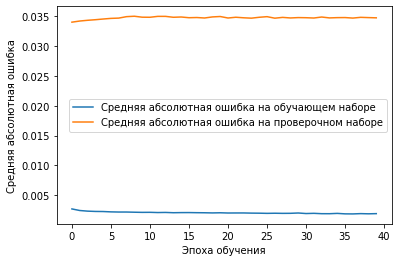

In [ ]:
#Простая Dense сеть
input1 = Input((xTrainScaled.shape[1],))
input2 = Input((xTrainC01.shape[1],))

x1 = Dense(10, activation="relu")(input1)
x2 = Dense(250, activation="relu")(input2)

x = concatenate([x1, x2])

x = Dense(100, activation='relu')(x)
x = Dense(10, activation='relu')(x)
x = Dense(1, activation='linear')(x)

model = Model((input1, input2), x)

model.compile(optimizer=Adam(lr=1e-3), loss='mse')
history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], 
                    yTrainScaled[~valMask], 
                    epochs=20, 
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], 
                    yTrainScaled[valMask]), 
                    verbose=0,
                    callbacks=[pltMae])

print()
print('Меняем шаг обучения на 1e-4')
model.compile(optimizer=Adam(lr=1e-4), loss='mse')
history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], 
                    yTrainScaled[~valMask], 
                    epochs=40, 
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], 
                    yTrainScaled[valMask]), 
                    verbose=0,
                    callbacks=[pltMae])

print()
print('Меняем шаг обучения на 1e-5')
model.compile(optimizer=Adam(lr=1e-5), loss='mse')
history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], 
                    yTrainScaled[~valMask], 
                    epochs=40, 
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], 
                    yTrainScaled[valMask]), 
                    verbose=0,
                    callbacks=[pltMae])

#print()
#print('Меняем шаг обучения на 1e-6')
#model.compile(optimizer=Adam(lr=1e-6), loss='mse')
#history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], 
#                    yTrainScaled[~valMask], 
#                    epochs=40, 
#                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], 
#                    yTrainScaled[valMask]), 
#                    verbose=0,
#                    callbacks=[pltMae])

#print()
#print('Меняем шаг обучения на 1e-7')
#model.compile(optimizer=Adam(lr=1e-7), loss='mse')
#history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], 
#                    yTrainScaled[~valMask], 
#                    epochs=40, 
#                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], 
#                    yTrainScaled[valMask]), 
#                    verbose=0,
#                    callbacks=[pltMae])




#Проверяем результаты
pred = model.predict([xTrainScaled[valMask], xTrainC01[valMask]]) #Полуаем выход сети на проверочной выборке
predUnscaled = yScaler.inverse_transform(pred).flatten() #Делаем обратное нормирование выхода к изначальным величинам цен квартир
yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[valMask]).flatten() #Делаем такое же обратное нормирование yTrain к базовым ценам
delta = predUnscaled - yTrainUnscaled #Считаем разность предсказания и правильных цен
absDelta = abs(delta) #Берём модуль отклонения
print("Модуль ошибки", sum(absDelta) / (1e+6 * len(absDelta))) #Выводим усреднённую ошибку в миллионах рублей

#ВЫводим графики ошибки
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

**В задаче Light фактически повторили нейронку с вебинара на основе шаблона с готовыми функциями парсинга и подготовки данных.
Пытался я запустить нейронку со всеми данными, но из-за нехватки памяти запускал как в вебинаре  - только по однушкам.** 

**Далее в задании Pro будем делать собственную функцию callback**




##PRO задание. Вариант 3##

В одной из баз - hh или **квартиры**, сделайте callback, который будет выводить на каждой эпохе:

1. Текущую mae
2. График mae по всем эпохам на обучающей и проверочная выборках
3. Текущий scatter
4. Текущую гистограмму ошибок
5. Время обучения на эпохе, время обучения суммарное и сколько времени остаётся до конца обучения
6. Изменял бы шаг обучения, если начинается “пила” или mae выходит на плато
7. Сохраняет в .h5 сеть с лучшей точностью

*желательно использовать clear_output и verbose=0

**callback должен быть самописный, нельзя использовать готовые

In [ ]:
#загрузим готовые массивы, подготовленные в Light с диска
#xTrainScaled = np.load('/content/drive/My Drive/my_sample_data/Д.З.19/xTrainScaled.npy')
#xTrainC01 = np.load('/content/drive/My Drive/my_sample_data/Д.З.19/xTrainC01.npy')
#yTrainScaled = np.load('/content/drive/My Drive/my_sample_data/Д.З.19/yTrainScaled.npy')

#print(xTrainScaled.shape)
#print(xTrainC01.shape)
#print(yTrainScaled.shape)

(62504, 109)
(62504, 2000)
(62504, 1)


##Callback

In [ ]:
###################################################
# Колбэк отображающий информацию о времени обучения
###################################################
class Times_Monitor(Callback):
  
  def __init__(self):
    #Запоминаем стартовое время начала работы
    self.start_datetime = datetime.datetime.now()
    #print(self.start_datetime)


  def on_epoch_begin(self, epoch, logs={}):
    self.epoch_time_start = time.time()  #запоминаем время начала эпохи
    #print(self.epoch_time_start)

  def on_epoch_end(self, epoch, logs=None):
    #print(logs)
    
    # Время обучения на эпохе, время обучения суммарное и сколько времени остаётся до конца обучения
    current_datetime = datetime.datetime.now()
    diff = current_datetime - self.start_datetime  
    avg_time_per_epoch = (diff / (epoch + 1))
    left_epochs = (self.params['epochs'] - (epoch + 1))
    left_time = avg_time_per_epoch * left_epochs

    clear_output()
    print('Эпоха: {:>3.0f}'.format(epoch), \
          '  Прошло со старта,сек: {:>5.2f}'.format(diff.total_seconds()), \
          '  Среднее время на эпоху,сек: {:>5.2f}'.format(avg_time_per_epoch.total_seconds()), \
          '  Осталось эпох: {:>3.0f}'.format(left_epochs), \
          '  Осталось,сек: {:>5.2f}'.format(left_time.total_seconds()))
    print('')


######################################################################
# Колбэк выводящий текущую mae, рисующий графики, и сохраняющий модель
######################################################################
class MAE_etc(Callback):

  def __init__(self): 
    self.mae_list = []
    self.val_mae_list = []

  @staticmethod
  def get_mae(train_or_validation):
    if (train_or_validation):
      mask = ~valMask
    else:
      mask = valMask
    pred =  model.predict([xTrainScaled[mask], xTrainC01[mask]])             #Получаем выход сети на выборке
    predUnscaled = yScaler.inverse_transform(pred).flatten()                 #Делаем обратное нормирование выхода
    yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[mask]).flatten() #Делаем такое же обратное нормирование yTrain
    delta = predUnscaled - yTrainUnscaled                                    #Считаем разность предсказания и правильных цен
    absDelta = abs(delta)                                                    #Берём модуль отклонения
    mae = sum(absDelta) / (1e+6 * len(absDelta))
    return mae  
 
  def plot_mae(self):
    plt.plot(self.mae_list, label='Средняя абсолютная ошибка на обучающем наборе')
    plt.plot(self.val_mae_list, label='Средняя абсолютная ошибка на проверочном наборе')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Средняя абсолютная ошибка')
    plt.legend()
    plt.show()

  @staticmethod
  def plot_scatter_and_hist(train_or_validation):
    if (train_or_validation):
      mask = ~valMask
    else:
      mask = valMask    
    pred = model.predict([xTrainScaled[mask], xTrainC01[mask]]) #Полуаем выход сети на проверочно выборке
    predUnscaled = yScaler.inverse_transform(pred).flatten()    #Делаем обратное нормирование выхода
    yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[mask]).flatten() #Делаем такое же обратное нормирование yTrain 
    delta = predUnscaled - yTrainUnscaled #Считаем разность предсказания и правильных цен
    absDelta = abs(delta) #Берём модуль отклонения
    
    plt.scatter(yTrainUnscaled[yTrainUnscaled<5e+7], predUnscaled[yTrainUnscaled<5e+7])
    plt.xlabel('Правильные значение')
    plt.ylabel('Предсказания')
    plt.axis('equal')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-1e+8, 1e+9], [-1e+8, 1e+9])
    plt.show()
    
    normalized_delta=abs(pred-yTrainScaled[valMask])
    bins_norm=[0.01*i for i in range(20)] #Разбиваем значения ошибок на 20 интервалов длиной 0.01
    plt.hist(normalized_delta.flatten(), bins = bins_norm)
    plt.xlabel("Значение ошибки")
    plt.ylabel("Количество")
    plt.show()


  def save_best_model(self):
    if (len(self.val_mae_list) < 2):
      model.save('best_net.h5')
    else:
      if (self.val_mae_list[-1] < np.array(self.val_mae_list[:-1]).min()):
        model.save('best_net.h5')
        print('Лучшая точность, сохраняем нейронку')


  def on_epoch_end(self, epoch, logs):
    mae = self.get_mae(1)
    val_mae = self.get_mae(0)

    self.mae_list.append(mae)
    self.val_mae_list.append(val_mae)

    curr_val_mae_list.append(mae)
  
    #clear_output()
    
    #Выводим усреднённую ошибку в миллионах рублей
    print('Модуль ошибки на обучающей выборке: ', round(mae,2), \
          '  Модуль ошибки на проверочной выборке: ', round(val_mae,2))       
    print('')

    #рисуем графики
    self.plot_scatter_and_hist(0)
    self.plot_mae()

    #и сохраняем модель
    self.save_best_model()



##########################################################
# Функция изменения шага обучения

a = [0.001]
curr_val_mae_list = []

def scheduler(epoch):

  std = np.array(curr_val_mae_list[-5:]).std()
  print("Среднеквадратичное отклонение", round(std,4))
  v = 0.001
  if len(curr_val_mae_list) < 5:
    return v
  if (std > 0.2):
    print("Пила, понижаем скорость")
    v=0.0001
    a.append(0.0001)
    return v
  if (std < 0.002):
    print("Плато, повышаем скорость")
    v = 0.01
    a.append(0.01)
    return v
  else: return a[-1]


Callback_LR = LearningRateScheduler(scheduler)

  

In [ ]:
#Простая Dense сеть 

all_epohs = 20
Lrate = 1e-3


input1 = Input((xTrainScaled.shape[1],))
input2 = Input((xTrainC01.shape[1],))

x1 = Dense(10, activation="relu")(input1)
x2 = Dense(25, activation="relu")(input2)

x = concatenate([x1, x2])

x = Dense(20, activation='relu')(x)
#x = Dense(10, activation='relu')(x)
x = Dense(1, activation='linear')(x)

model = Model((input1, input2), x)

Эпоха:  19   Прошло со старта,сек: 141.95   Среднее время на эпоху,сек:  7.10   Осталось эпох:   0   Осталось,сек:  0.00

Модуль ошибки на обучающей выборке:  1.16   Модуль ошибки на проверочной выборке:  1.48



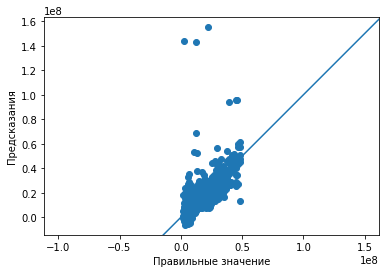

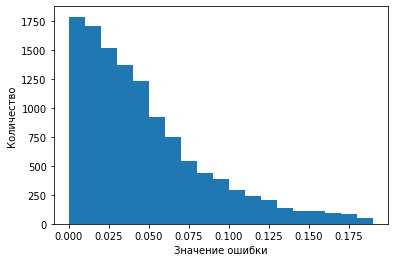

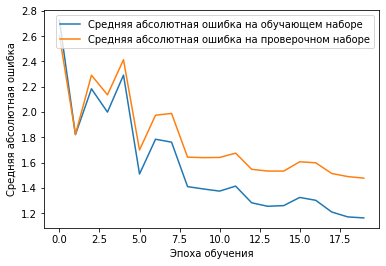

Лучшая точность, сохраняем нейронку


In [ ]:
#Компилируем модель и запускаем обучение


model.compile(optimizer=Adam(learning_rate=Lrate), loss='mse')
history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], 
                    yTrainScaled[~valMask], 
                    epochs=all_epohs, 
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], 
                    yTrainScaled[valMask]), 
                    verbose=0,
                    callbacks=[Times_Monitor(), MAE_etc(), Callback_LR]
                    )




**Сделал через класс keras.callbacks.Callback. Разделил функционал на три колбэка.**